# 第2回 金融データ活用チャレンジチュートリアル
このチュートリアルは分析コンペティションに初めて参加する方にも取り組んでいただけるように作成しています。
はじめの一歩として、ぜひ参考にしてみてください。

## 1.課題を理解しましょう。
企業が返済不能になるかどうかの予測に挑戦して頂きます。

> 今回は企業向けローンの返済可否予測というテーマを通して、ローンに関連したデータを基に、企業が返済不能になるかどうかの予測に挑戦して頂きます。このデータを活用することで、どの業種や地域が成長の機会を持っているか、あるいはどのような要因がビジネスの成功に影響を与えるかなど、金融機関は効果的な企業支援の戦略を立てることができます。

## 2.データをダウンロードしましょう。
以下のURLからデータをダウンロードします。
https://signate.jp/competitions/1337/data

## 3.環境を整えましょう。
dataフォルダを作り、ダウンロードしたデータをdataフォルダに入れましょう。
その後dataフォルダの入っているディレクトリと同じ場所にこのjupyter notebookを準備しましょう。
また、解析に用いるモジュールを随時インポートしましょう。
このチュートリアルでは次に挙げているモジュールを用いているので、走らせる場合はインストールしておきましょう。
pandas, numpy, matplotlib, lightgbm, sklearn, seaborn

## 4.データを読み込みましょう
データまでのパスを適切に設定してpandasに読み込ませましょう。

In [2]:
import pandas as pd

train = pd.read_csv('../dataset/train.csv', index_col=0) # 学習用データ
test = pd.read_csv('../dataset/test.csv', index_col=0) # 学習用データ   # 評価用データ
sample_submit = pd.read_csv('../dataset/sample_submission.csv', index_col=0, header=None) # 応募用サンプルファイル
train.shape
test.shape
sample_submit.shape

(42308, 1)

## 5.データの概要を確認しましょう。
学習用データのカラムの一覧をまず確認しましょう。

In [3]:
train.dtypes.index
train[['SBA_Appv']].describe()

,SBA_Appv
count,42307
unique,2005
top,"$25,000.00"
freq,2382


次に、読み込んだ学習用データの先頭5行を表示してみましょう。

In [3]:
train.head(5)
train.

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,DisbursementDate,MIS_Status,Sector,ApprovalDate,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural
0,163,21,1.0,0,0,1,N,N,31-Jan-98,1,0,22-Sep-06,2006,PHOENIX,AZ,SD,"$80,000.00","$80,000.00","$68,000.00",0
1,84,6,1.0,4,0,0,0,N,31-Oct-93,1,62,30-Jun-92,1992,MCALESTER,OK,OK,"$287,000.00","$287,000.00","$229,600.00",0
2,242,45,1.0,4,90,0,N,N,31-Aug-01,1,42,18-Apr-01,2001,HAWTHORNE,NJ,NJ,"$31,983.00","$30,000.00","$15,000.00",1
3,237,4,1.0,0,0,0,N,N,31-Aug-07,1,33,6-Oct-03,2004,NASHVILLE,TN,SD,"$229,000.00","$229,000.00","$229,000.00",0
4,184,0,1.0,0,0,0,N,N,8-Jun-83,1,0,17-Dec-99,2000,POMONA,CA,CA,"$525,000.00","$525,000.00","$393,750.00",0


1行で1つの貸し借りの情報を表していて、それのカラムは全部で20種類あることがわかります。
各カラムの意味はデータタブに記載されているので、それと照らし合わせて確認できます。
MIS_Status(ローンの状態)が今回の予測の対象である目的変数です。0は債務不履行、1は完済を表しています。
評価用データ（test.csv）には目的変数（MIS_Status）はありません。その他のカラムは学習用データと同じです。
つまり、答えが存在している学習用データ（train.csv）を元にして評価用データでのMIS_Status(ローンの状態)を予測することが今回の課題となっています。

## 6.前処理を行いましょう
機械学習で精度を上げるためにはデータを綺麗にする前処理が必要になります。
このデータでは金額の頭に'$'がついているため、まずはそれを取り除き数値データに直す必要があります。

In [4]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

,DisbursementGross,GrAppv,SBA_Appv
0,"$80,000.00","$80,000.00","$68,000.00"
1,"$287,000.00","$287,000.00","$229,600.00"
2,"$31,983.00","$30,000.00","$15,000.00"
3,"$229,000.00","$229,000.00","$229,000.00"
4,"$525,000.00","$525,000.00","$393,750.00"


In [5]:
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']]= \
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

test[['DisbursementGross',  'GrAppv', 'SBA_Appv']]= \
test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
  
train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].head()

/tmp/ipykernel_1679237/1307329474.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  train[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))
/tmp/ipykernel_1679237/1307329474.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  test[['DisbursementGross',  'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))


,DisbursementGross,GrAppv,SBA_Appv
0,80000.00,80000.00,68000.00
1,287000.00,287000.00,229600.00
2,31983.00,30000.00,15000.00
3,229000.00,229000.00,229000.00
4,525000.00,525000.00,393750.00


次に欠損値の処理をするために、欠損値を探してみましょう。

In [6]:
train.isnull().sum()

Term                    0
NoEmp                   0
NewExist                0
CreateJob               0
RetainedJob             0
FranchiseCode           0
RevLineCr            1079
LowDoc                531
DisbursementDate      150
MIS_Status              0
Sector                  0
ApprovalDate            0
ApprovalFY              0
City                    0
State                   0
BankState              11
DisbursementGross       0
GrAppv                  0
SBA_Appv                0
UrbanRural              0
dtype: int64

RevLineCr、LowDoc、DisbursementDate、BankStateの4列に欠損が含まれていることがわかります。
簡単のためにこれらの欠損値は"NULL"というカテゴリーに置き換え、欠損している情報を残します。

In [7]:
train.fillna('NULL', inplace=True)

## 7.データの特徴を見てみましょう
まずは、各種数値データの特徴量を確認してみましょう。

In [8]:
train.describe()

,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,MIS_Status,Sector,ApprovalFY,UrbanRural
count,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000,42307.000000
mean,108.601673,9.704304,1.210414,2.183728,3.478148,1955.056019,0.892689,32.933439,2001.537783,0.585742
std,84.569847,17.488022,0.407608,5.093980,8.113648,10541.388765,0.309512,22.291386,5.860527,0.741929
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1974.000000,0.000000
25%,56.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,22.000000,1997.000000,0.000000
50%,82.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,33.000000,2003.000000,0.000000
75%,168.000000,12.000000,1.000000,2.000000,3.000000,1.000000,1.000000,44.000000,2006.000000,1.000000
max,360.000000,202.000000,2.000000,70.000000,140.000000,90709.000000,1.000000,81.000000,2014.000000,2.000000


目的変数と他の変数の関係を確認しましょう。
まず初めに、MIS_Status(ローンの状態)と他の数値データとの相関を見てみましょう。
そのためにまず、数字のカラムを取り出します。

In [9]:
numeric_columns = train.select_dtypes(include=['number']).columns
  
numeric_columns

Index(['Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'MIS_Status', 'Sector', 'ApprovalFY', 'UrbanRural'],
      dtype='object')

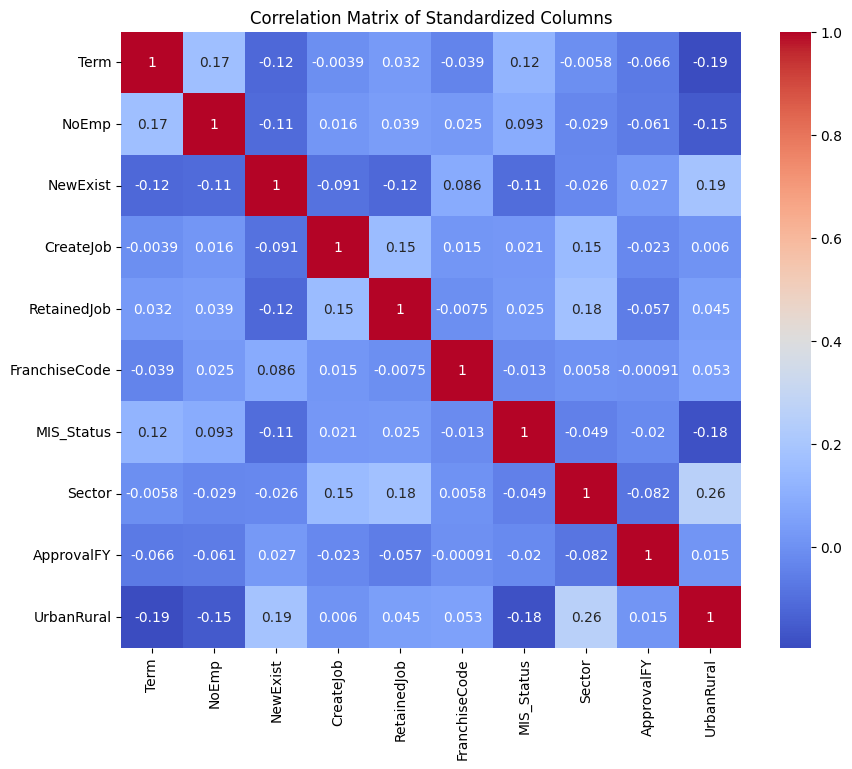

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# train[std_columns] の相関行列を求める
corr_matrix = train[numeric_columns].corr()
  
# 相関行列を図示
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Standardized Columns')
plt.show()

MIS_Status(ローンの状態)は他の数値データとは直接的な相関があまりないが、UrbanRural(都会か田舎か)とはやや相関があることが見られました。

## 8.学習モデルを作ってみましょう
チュートリアルでは簡単のため数値データのみに対してLightGBMと呼ばれる手法を用いて学習モデルを作ります。

In [11]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
  
train_numeric = train[numeric_columns]
  
# データの準備
X = train_numeric.drop('MIS_Status', axis=1)  # 特徴量
y = train_numeric['MIS_Status']               # 目的変数
  
# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  
# LightGBMモデルの設定
lgbm = lgb.LGBMClassifier()
  
# モデルの訓練
lgbm.fit(X_train, y_train)
  
# モデルの評価
y_pred = lgbm.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

[LightGBM] [Info] Number of positive: 30192, number of negative: 3653
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002383 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 751
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.892067 -> initscore=2.112028
[LightGBM] [Info] Start training from score 2.112028
Accuracy: 0.8994327582131884


このコンペティションの評価指標はMeanF1Score（MacroF1Score）ですので、それでスコアも計算してみます。

In [12]:
from sklearn.metrics import f1_score
  
mean_f1 = f1_score(y_test, y_pred, average='macro')
print(f'Mean F1 Score: {mean_f1}')

Mean F1 Score: 0.5691065243918456


学習したモデルにtestデータを入力すると、testデータに対するMIS_Statusを予測してくれます。
ただし、今回は数値データしか使っていないため、testデータの数値データのみを用いています。

In [13]:
predictions = lgbm.predict(test[numeric_columns.drop('MIS_Status')] )
# 結果を表示
print(predictions)

[0 1 1 ... 1 1 0]


## 9.予測結果を投稿してみましょう
応募用サンプルファイルで予測結果が格納されている1列目の値を、今回出力した予測結果に置き換えた上で、ヘッダ無しcsv形式のファイルとして保存しましょう。

In [14]:
predictions = lgbm.predict(test[numeric_columns.drop('MIS_Status')] )
# 結果を表示
print(predictions)
sample_submit[1] = predictions
sample_submit.to_csv('submit.csv', header=None)

## 10.より良い精度を出すためには
今回のチュートリアルでは簡単のために簡易的な前処理、特徴量選択、モデリングを行いました。
これよりもより良い精度を出すためには次のことを参考にしてみるのが良いかもしれません。
1. 数値データ以外の特徴量を学習に取り入れる。
2. チュートリアルでは比較的計算時間が短くて済むLightGBMを用いましたが、他の手法を試してみるのも良いかもしれません。また、ハイパーパラメータも色々変えて精度を向上させましょう。
3. 今回調べているのは、いわゆる「貸し倒れ確率」です。日本の個人向け融資では貸し倒れ確率は借りた額や借りる人の収入に主に依存することが知られています。この様な傾向が今回考えている米国中小向けのローンで成立するかをもし良かったら確認してみましょう。